### LDA example on 20newsgroups dataset

In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/chaix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# LDAvis
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head(15)

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


LDA is one the most popular topic modeling algs.

It is based om the Bayes Probabilistic Theory and its theory is quite complex.

Main assumptions:
- every document is a mixture of some number of topics;
- every word (kyeyword or token) is connected with some topis with certain probability;
- topics in the document have Dirichlet distribution.

There are two hyperparameters that control document and topic similarity, known as alpha and beta, respectively. A low value of alpha will assign fewer topics to each document whereas a high value of alpha will have the opposite effect. A low value of beta will use fewer words to model a topic whereas a high value will use more words, thus making topics more similar between them.

(https://monkeylearn.com/blog/introduction-to-topic-modeling/#:~:text=Topic%20modeling%20is%20an%20unsupervised,characterize%20a%20set%20of%20documents.)

In [15]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]

data = [re.sub(r'[^\w\s]',' ', sent) for sent in data]
data = [re.sub(r'[^a-zA-Z0-9]', ' ', sent) for sent in data]

pprint(data[:1])

['From   wheres my thing  Subject  WHAT car is this   Nntp Posting Host  rac3 '
 'wam umd edu Organization  University of Maryland  College Park Lines  15 I '
 'was wondering if anyone out there could enlighten me on this car I saw the '
 'other day  It was a 2 door sports car  looked to be from the late 60s  early '
 '70s  It was called a Bricklin  The doors were really small  In addition  the '
 'front bumper was separate from the rest of the body  This is all I know  If '
 'anyone can tellme a model name  engine specs  years of production  where '
 'this car is made  history  or whatever info you have on this funky looking '
 'car  please e mail  Thanks    IL      brought to you by your neighborhood '
 'Lerxst      ']


In [16]:
# tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[50])
print(len(data_words))

['from', 'john', 'collins', 'subject', 'problem', 'with', 'mit', 'shm', 'organization', 'boston', 'university', 'lines', 'am', 'trying', 'to', 'write', 'an', 'image', 'display', 'program', 'that', 'uses', 'the', 'mit', 'shared', 'memory', 'extension', 'the', 'shared', 'memory', 'segment', 'gets', 'allocated', 'and', 'attached', 'to', 'the', 'process', 'with', 'no', 'problem', 'but', 'the', 'program', 'crashes', 'at', 'the', 'first', 'call', 'to', 'xshmputimage', 'with', 'the', 'following', 'message', 'error', 'of', 'failed', 'request', 'badshmseg', 'invalid', 'shared', 'segment', 'parameter', 'major', 'opcode', 'of', 'failed', 'request', 'mit', 'shm', 'minor', 'opcode', 'of', 'failed', 'request', 'shmputimage', 'segment', 'id', 'in', 'failed', 'request', 'serial', 'number', 'of', 'failed', 'request', 'current', 'serial', 'number', 'in', 'output', 'stream', 'like', 'said', 'did', 'error', 'checking', 'on', 'all', 'the', 'calls', 'to', 'shmget', 'and', 'shmat', 'that', 'are', 'necessary'

In [17]:
for doc in range(10):
  print(len(data_words[doc]))

115
122
291
102
150
349
75
401
44
226


In [20]:
# Build the bigram and trigram models
# Example: 'Educationnal system', 'Energy access'
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=120) # higher threshold =>> fewer number of bigrams.
trigram = gensim.models.Phrases(bigram[data_words], threshold=120)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [29]:
# Trigram example
print(trigram_mod[bigram_mod[data_words[8]]])

['from', 'subject', 'win', 'icon', 'help', 'please', 'organization', 'university', 'of', 'northern_iowa', 'lines', 'have', 'win', 'and', 'downloaded', 'several', 'icons', 'and', 'bmps', 'but', 'cant', 'figure', 'out', 'how', 'to', 'change', 'the', 'wallpaper', 'or', 'use', 'the', 'icons', 'any', 'help', 'would', 'be', 'appreciated', 'thanx', 'brando', 'ps', 'please', 'mail', 'me']


In [30]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[5])

['foxvog_dougla', 'reword', 'vtt', 'line', 'article', 'tavare', 'write', 'article', 'write', 'article', 'tavare', 'write', 'article', 'write', 'massive', 'destructive', 'power', 'many', 'modern', 'weapon', 'make', 'cost', 'accidental', 'crimial', 'usage', 'weapon', 'great', 'weapon', 'mass_destruction', 'need', 'control', 'government', 'individual', 'access', 'would', 'result', 'needless', 'death', 'million', 'make', 'right', 'people', 'keep', 'bear', 'many', 'modern', 'weapon', 'thank', 'state', 'be', 'come', 'needless', 'say', 'disagree', 'count', 'believe', 'individual', 'right', 'weapon', 'mass_destruction', 'find', 'hard', 'believe', 'would', 'support', 'neighbor', 'right', 'keep', 'nuclear_weapon', 'biological', 'weapon', 'nerve_gas', 'property', 'can', 'even', 'agree', 'keep', 'weapon', 'mass_destruction', 'hand', 'individual', 'hope', 'sign', 'blank', 'check', 'course', 'term', 'must', 'rigidly', 'define', 'bill', 'say', 'weapon', 'mean', 'say', 'weapon', 'mean', 'sweeper', 'sh

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [34]:
[[(id2word[id], freq) for id, freq in enumerate(cp)] for cp in corpus[:1]]

[[('addition', (0, 1)),
  ('body', (1, 1)),
  ('bring', (2, 1)),
  ('call', (3, 1)),
  ('car', (4, 5)),
  ('could', (5, 1)),
  ('day', (6, 1)),
  ('door', (7, 2)),
  ('early', (8, 1)),
  ('engine', (9, 1)),
  ('enlighten', (10, 1)),
  ('funky', (11, 1)),
  ('history', (12, 1)),
  ('host', (13, 1)),
  ('info', (14, 1)),
  ('know', (15, 1)),
  ('late', (16, 1)),
  ('lerxst', (17, 1)),
  ('line', (18, 1)),
  ('look', (19, 2)),
  ('mail', (20, 1)),
  ('make', (21, 1)),
  ('model', (22, 1)),
  ('name', (23, 1)),
  ('neighborhood', (24, 1)),
  ('nntp_poste', (25, 1)),
  ('park', (26, 1)),
  ('production', (27, 1)),
  ('really', (28, 1)),
  ('rest', (29, 1)),
  ('see', (30, 1)),
  ('separate', (31, 1)),
  ('small', (32, 1)),
  ('spec', (33, 1)),
  ('sport', (34, 1)),
  ('thank', (35, 1)),
  ('thing', (36, 1)),
  ('where', (37, 1)),
  ('wonder', (38, 1)),
  ('year', (39, 1))]]

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

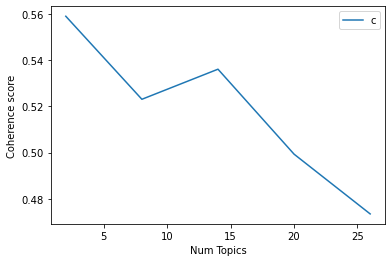

In [41]:
# Evaluete optimal num_topics. Long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=6)

# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [43]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"line" + 0.010*"write" + 0.010*"would" + 0.007*"say" + 0.006*"know" + '
  '0.006*"people" + 0.006*"make" + 0.006*"article" + 0.006*"think" + '
  '0.006*"be"'),
 (1,
  '0.107*"ax" + 0.012*"drive" + 0.010*"line" + 0.010*"file" + 0.009*"use" + '
  '0.009*"window" + 0.008*"program" + 0.008*"thank" + 0.007*"card" + '
  '0.007*"system"')]


In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.908765828185536

Coherence Score:  0.5590286983659263


In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.206636  0.0       1        1  83.406149
1     -0.206636  0.0       2        1  16.593851, topic_info=         Term          Freq         Total Category  logprob  loglift
3710       ax  20918.000000  20918.000000  Default  30.0000  30.0000
354     drive   3210.000000   3210.000000  Default  29.0000  29.0000
169       use   4751.000000   4751.000000  Default  28.0000  28.0000
331      file   2235.000000   2235.000000  Default  27.0000  27.0000
18       line  12400.000000  12400.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
223       set    744.521239   1580.023280   Topic2  -5.5670   1.0437
742   include    748.048967   1873.044608   Topic2  -5.5623   0.8783
442      work    781.875373   3462.048886   Topic2  -5.5181   0.3082
13       host    726.114159   4154.240250   Topic2  -5.5921   0.0520
401      help    685.043475   2156.958402   Topic2  -5.6503   0.6492

[150 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
406       1  0.879839         also
406       2  0.120279         also
817       1  0.163917  application
817       2  0.836101  application
175       1  0.999822      article
...     ...       ...          ...
325       2  0.000104        would
197       1  0.998466        write
197       2  0.001605        write
39        1  0.999887         year
39        2  0.000285         year

[236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [46]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.908765356950655

Coherence Score:  0.5590286983659263
